In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head() #preview

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.isnull().sum() #preview nulls

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train['target'].value_counts(normalize=True) #check target distribution

0    0.57034
1    0.42966
Name: target, dtype: float64

In [6]:
train['location'].fillna('', inplace=True) #fill blank location text with an empty string

In [7]:
train['loc_y_text'] = train['location'] + ' ' + train['text'] #concatenate text into single column

In [8]:
train.head() #preview

,id,keyword,location,text,target,loc_y_text
0,1,NaN,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake ...
1,4,NaN,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are...
3,6,NaN,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation o..."
4,7,NaN,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as...


## EDA

I'm going to look at the top recurring words for each binary subcategory. I'll be importing a function I wrote for an NLP Reddit Scraping project during DSI.

In [9]:
train_1 = train[train['target']==1]

In [10]:
train_0 = train[train['target']==0]

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [19]:
from matplotlib import pyplot as plt

In [37]:
from nltk.corpus import stopwords
swords = set(stopwords.words('english')) #set nltk stopword list equal to a variable
swords.update(['usa', 'wa', 'amp', 'new'])
 #add words to stopwords list
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+') #create tokenizer to remove punctuation
cvec = CountVectorizer(stop_words=swords, #remove stop words
                       ngram_range=(1,3), #single and paired words
                       max_df=.4, #ngram has to appear in 40% or less of posts
                       min_df=3, #ngram has to appear at least 4 times
                       max_features=20_000) #maximum 20k features

def tokemmetizer(dataframe): #create function to tokenize and lemmatize
    X = dataframe['loc_y_text']
    X_tokens = [tokenizer.tokenize(word) for word in X] #tokenize all words
    X_lem = []
    for item in X_tokens:
        X_post = []
        for word in item:
            X_post.append(lemmatizer.lemmatize(word)) #remove stop words
        X_lem.append(' '.join(X_post)) #rejoin lemmatized word list into strings
    print(type(X_lem))
    X_c = cvec.fit_transform(X_lem) #pass posts through count vectorizer
    X_c_df = pd.DataFrame(X_c.todense(), columns=cvec.get_feature_names()) #make df showing word frequency
    return X_c_df #return dataframe of values 

In [38]:
real_df = tokemmetizer(train_1)
fake_df = tokemmetizer(train_0)

<class 'list'>
<class 'list'>


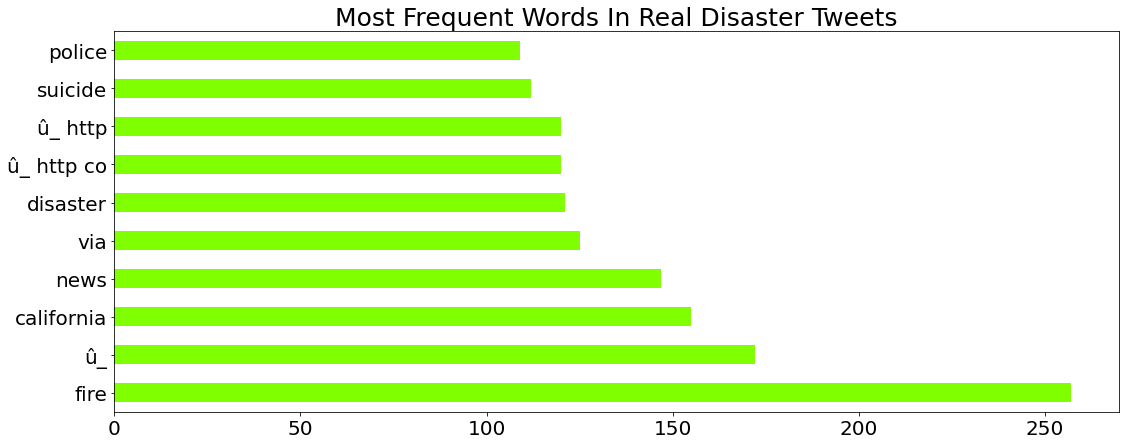

In [39]:
plt.figure(figsize=(18,7))
real_df.sum().sort_values(ascending=False).head(10).plot.barh(
    fontsize = '20',
    color='chartreuse'); #make bar chart of most frequent 10 words  
plt.title('Most Frequent Words In Real Disaster Tweets', size=25);

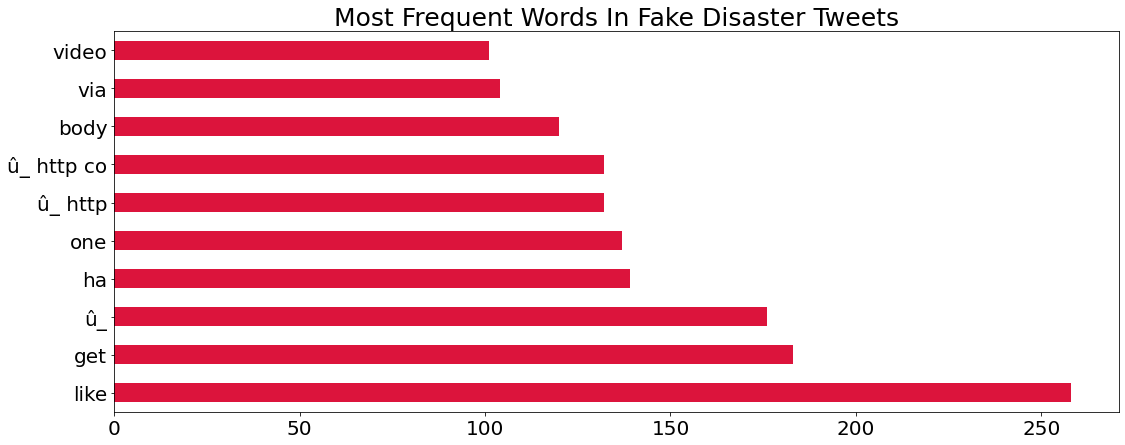

In [40]:
plt.figure(figsize=(18,7))
fake_df.sum().sort_values(ascending=False).head(10).plot.barh(
    fontsize = '20',
    color='crimson'); #make bar chart of most frequent 10 words  
plt.title('Most Frequent Words In Fake Disaster Tweets', size=25);

I can continue to tweak the stopwords / parameters and try to further differentiate the results but for this preliminary analysis, here are a few takeaways.  
Keywords in True disasters:  
- disaster
- california
- news
- suicide
- police
- fire  

Keywords in non-disasters:  
- video
- body
- one
- like
- get

I should save my dataframes so I can import them into my modeling notebook; I'll save just the two columns I need, the classification and the concatenated text column.

In [43]:
train2 = train.copy() #copy in case of mistake

In [44]:
train2 = train2[['target', 'loc_y_text']]

In [45]:
train2

,target,loc_y_text
0,1,Our Deeds are the Reason of this #earthquake ...
1,1,Forest fire near La Ronge Sask. Canada
2,1,All residents asked to 'shelter in place' are...
3,1,"13,000 people receive #wildfires evacuation o..."
4,1,Just got sent this photo from Ruby #Alaska as...
...,...,...
7608,1,Two giant cranes holding a bridge collapse in...
7609,1,@aria_ahrary @TheTawniest The out of control ...
7610,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. ht...
7611,1,Police investigating after an e-bike collided...


In [46]:
train2.isnull().sum() #verifying no null values

target        0
loc_y_text    0
dtype: int64

In [47]:
train2.to_csv('training_clean.csv', index=False) #save to csv file

Time to try out a few classification models